In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
# For importing Roberta installing transformers library
!pip install transformers

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.init as init

from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tqdm import tqdm

from transformers import RobertaTokenizer, RobertaModel

import re
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

Loading csv files

In [5]:
df_train = pd.read_csv("/content/drive/MyDrive/NLP3/NLP3/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/NLP3/NLP3/test.csv")
print(df_train.shape)
print(df_test.shape)

(2000, 3)
(500, 3)


In [6]:
df_train.head()

,index,text,label
0,0,Zimbabwe annual inflation drops to 209 percent...,0
1,1,"More than 1,000 dead in Haiti (09/23/04)-- A m...",0
2,2,Seven die in Japan #39;suicide pact #39; Japa...,0
3,3,Security No. 1 for Afghan head President Hamid...,0
4,4,Palestinians say they hope Bush accepts dealin...,0


Function to do the preprocessing. Make the text lowercase, removed unnecessary symbols, Replace all \\\ with " ". I havent remove the stopwords as it is told not to remove them

In [7]:
def preprocess_text(text):
  text = text.lower()

  text = text.replace('\\',' ')

  text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

  tokens = word_tokenize(text)
  words = [w for w in tokens]

  text = ' '.join(words)
  return text

In [8]:
df_train['preprocess_text'] = df_train['text'].apply(preprocess_text)
df_test['preprocess_text'] = df_test['text'].apply(preprocess_text)

Calculating the word count of each sentence in train dataset so as to see the distribution of no. of words in the sentences.

In [9]:
word_count_in_sentences = []
for index, row in df_train.iterrows():
  text = row['preprocess_text'].split()
  word_count_in_sentences.append(len(text))

word_count = np.array(word_count_in_sentences)

In [10]:
print(word_count.max())
print(word_count.min())
print(np.mean(word_count))
print(np.median(word_count))

135
11
38.125
38.0


(array([  92.,  698., 1038.,  125.,   28.,   10.,    2.,    4.,    0.,
           3.]),
 array([ 11. ,  23.4,  35.8,  48.2,  60.6,  73. ,  85.4,  97.8, 110.2,
        122.6, 135. ]),
 <BarContainer object of 10 artists>)

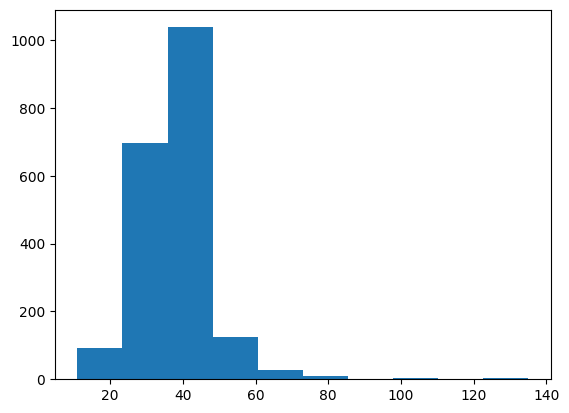

In [11]:
plt.hist(word_count)

Calculating the word count of each sentence in test dataset so as to see the distribution of no. of words in the sentences.

In [12]:
word_count_in_sentences_test = []
for index, row in df_test.iterrows():
  text = row['preprocess_text'].split()
  word_count_in_sentences_test.append(len(text))

word_count_test = np.array(word_count_in_sentences_test)

In [13]:
print(word_count_test.max())
print(word_count_test.min())
print(np.mean(word_count_test))
print(np.median(word_count_test))

80
16
36.782
36.0


(array([ 26.,  55., 150., 144.,  74.,  33.,   8.,   5.,   4.,   1.]),
 array([16. , 22.4, 28.8, 35.2, 41.6, 48. , 54.4, 60.8, 67.2, 73.6, 80. ]),
 <BarContainer object of 10 artists>)

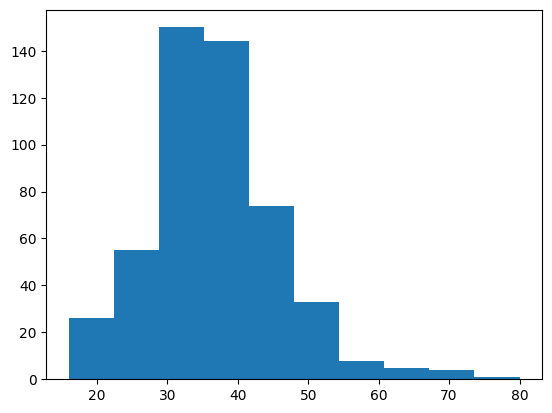

In [14]:
plt.hist(word_count_test)

As maximum length of sentence is 135 and minimum is 11 as well as mean is around 38 for train dataset. Similarly, for the test dataset max,min and average lenght of sentence are 80,16 and 36. So I have set max_sequence_length =  150 ensures that there is no loss of data during training as well as testing while still staying within the limits of RoBERTa's tokenization constraints which are 512.

In [15]:
# Define maximum sequence length
max_seq_length = 150

# Initialize RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In the dataset class only, the code to pad or truncate the sentence based on max_seq_length is written. So, as to ensure that each sentence in the dataset is tokenized and padded/truncated correctly as per the max_seq_length defined.

In [16]:
class RobertaDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_seq_length):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence = self.data.iloc[idx]['preprocess_text']
        label = self.data.iloc[idx]['label']

        # Tokenize and pad the sentence
        encoding = self.tokenizer.encode_plus(
            sentence,
            max_length=self.max_seq_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)

        return input_ids, attention_mask, label

Splitting the train data into 90% train and 10% valid data as per told in the assignment.

In [17]:
df_train, df_valid = train_test_split(df_train, test_size = 0.1, random_state=42)
print(df_train.shape)
print(df_valid.shape)

(1800, 4)
(200, 4)


Created a train, valid and test dataset using custom RobertaDataset class and convert these dataset to dataloader for passing to the model.

In [18]:
# Create train and test datasets
train_dataset = RobertaDataset(df_train, tokenizer, max_seq_length)
valid_dataset = RobertaDataset(df_valid, tokenizer, max_seq_length)
test_dataset = RobertaDataset(df_test, tokenizer, max_seq_length)

In [19]:
# Define batch size
batch_size = 8

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Roberta Classifier is the model class in which 1st layer is pretrained Roberta model with "RoBERTa-base” checkpoint imported from the huggingface Tranformers library. I have added a 2 layer classification head on to this Roberta model so as to perform classification task.

In [20]:
class RobertaClassifier(nn.Module):

    def __init__(self, dropout=0.5):
        super(RobertaClassifier, self).__init__()

        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.dropout = nn.Dropout(dropout)
        self.linear1 = nn.Linear(768, 64)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(64, 4)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear1(dropout_output)
        final_layer = self.relu(linear_output)
        # No need for a softmax, because it is already included in the CrossEntropyLoss
        logits = self.linear2(final_layer)
        return logits

# Usage
model = RobertaClassifier()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Function to train the model with standard training loop of pytorch. I have set learning rate as 1e-6 and  no of epochs = 10. Also, best model to be saved and used for testing is decide based on the validation loss.

In [21]:
total_params = sum(p.numel() for p in model.parameters())
total_params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", total_params)
print("Number of trainable parameters: ", total_params_trainable)

Number of parameters:  124695108
Number of trainable parameters:  124695108


In [22]:
def train(model, train_dataloader, val_dataloader, learning_rate, epochs):

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    train_loss_BERT = []
    train_acc_BERT = []
    val_loss_BERT = []
    val_acc_BERT = []

    best_val_loss = float('inf')
    best_epoch = -1
    best_model_path_BERT = " "

    for epoch in range(epochs):

        total_acc_train = 0
        total_loss_train = 0

        model.train()  # Set model to training mode

        for train_input in tqdm(train_dataloader):
            input_ids, attention_mask, train_label = train_input
            train_label = train_label.to(device)
            mask = attention_mask.to(device)
            input_id = input_ids.to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        model.eval()  # Set model to evaluation mode

        with torch.no_grad():
            for val_input in val_dataloader:
                input_ids, attention_mask, val_label = val_input
                val_label = val_label.to(device)
                mask = attention_mask.to(device)
                input_id = input_ids.to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        # Calculate metrics
        avg_train_loss = total_loss_train / len(train_dataloader)
        avg_train_acc = total_acc_train / len(train_dataloader.dataset)
        avg_val_loss = total_loss_val / len(val_dataloader)
        avg_val_acc = total_acc_val / len(val_dataloader.dataset)

        # Append to lists
        train_loss_BERT.append(avg_train_loss)
        train_acc_BERT.append(avg_train_acc)
        val_loss_BERT.append(avg_val_loss)
        val_acc_BERT.append(avg_val_acc)

        print(
            f'Epochs: {epoch + 1} | Train Loss: {avg_train_loss: .3f} \
            | Train Accuracy: {avg_train_acc: .3f} \
            | Val Loss: {avg_val_loss: .3f} \
            | Val Accuracy: {avg_val_acc: .3f}')

        # Check if current validation loss is the best so far
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            best_model_path_BERT = f"best_model_path_LSTM_{epoch}.pth"
            torch.save(model.state_dict(), best_model_path_BERT)

    return train_loss_BERT, train_acc_BERT, val_loss_BERT, val_acc_BERT, best_val_loss, best_epoch, best_model_path_BERT


EPOCHS = 10
LR = 1e-6

train_losses_BERT, train_acc_BERT, val_losses_BERT, val_acc_BERT, best_val_loss, best_epoch, best_model_path_BERT = train(model, train_dataloader, valid_dataloader, LR, EPOCHS)

print(f"Best Validation Loss: {best_val_loss}, best epoch :{best_epoch}, best saved model path: {best_model_path_BERT}")

100%|██████████| 225/225 [00:47<00:00,  4.72it/s]


Epochs: 1 | Train Loss:  1.390             | Train Accuracy:  0.245             | Val Loss:  1.383             | Val Accuracy:  0.265


100%|██████████| 225/225 [00:47<00:00,  4.78it/s]


Epochs: 2 | Train Loss:  1.333             | Train Accuracy:  0.399             | Val Loss:  1.135             | Val Accuracy:  0.800


100%|██████████| 225/225 [00:48<00:00,  4.67it/s]


Epochs: 3 | Train Loss:  0.939             | Train Accuracy:  0.840             | Val Loss:  0.724             | Val Accuracy:  0.890


100%|██████████| 225/225 [00:48<00:00,  4.65it/s]


Epochs: 4 | Train Loss:  0.695             | Train Accuracy:  0.881             | Val Loss:  0.563             | Val Accuracy:  0.900


100%|██████████| 225/225 [00:48<00:00,  4.65it/s]


Epochs: 5 | Train Loss:  0.573             | Train Accuracy:  0.893             | Val Loss:  0.490             | Val Accuracy:  0.900


100%|██████████| 225/225 [00:48<00:00,  4.65it/s]


Epochs: 6 | Train Loss:  0.492             | Train Accuracy:  0.906             | Val Loss:  0.450             | Val Accuracy:  0.895


100%|██████████| 225/225 [00:48<00:00,  4.65it/s]


Epochs: 7 | Train Loss:  0.441             | Train Accuracy:  0.918             | Val Loss:  0.420             | Val Accuracy:  0.900


100%|██████████| 225/225 [00:48<00:00,  4.65it/s]


Epochs: 8 | Train Loss:  0.394             | Train Accuracy:  0.923             | Val Loss:  0.402             | Val Accuracy:  0.895


100%|██████████| 225/225 [00:48<00:00,  4.65it/s]


Epochs: 9 | Train Loss:  0.361             | Train Accuracy:  0.929             | Val Loss:  0.388             | Val Accuracy:  0.895


100%|██████████| 225/225 [00:48<00:00,  4.64it/s]


Epochs: 10 | Train Loss:  0.327             | Train Accuracy:  0.940             | Val Loss:  0.383             | Val Accuracy:  0.895
Bet Validation Loss: 0.38308261752128603, best epoch :9, best saved model path: best_model_path_LSTM_9.pth


Plots are made of training and validation loss vs. epochs as well as training and validation accuracy vs. epochs. This help us to visualize about the training and decide the hyperparameters values.

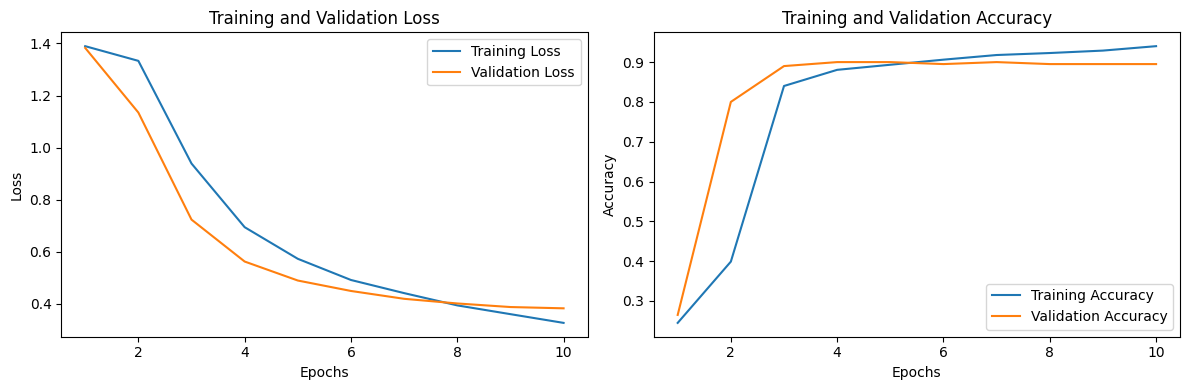

In [27]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_BERT, label='Training Loss')
plt.plot(epochs, val_losses_BERT, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_BERT, label='Training Accuracy')
plt.plot(epochs, val_acc_BERT, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Function to evaluate the best saved trained model as per the validation loss on the tess data. In this function, we are also saving the true labels, predicted labels and original senetences so that we can create the final csb file which has to be submitted.

In [28]:
def evaluate(model, test_dataloader, df_test, best_model_path_BERT):

    true_labels = []
    predicted_labels = []
    original_sentences = []
    # Load the previously saved best model
    model.load_state_dict(torch.load(best_model_path_BERT))
    model.eval()  # Set model to evaluation mode

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    with torch.no_grad():
        for i, test_input in enumerate(test_dataloader):
            input_ids, attention_mask, test_label = test_input
            test_label = test_label.to(device)
            mask = attention_mask.to(device)
            input_id = input_ids.to(device)
            output = model(input_id, mask)

            # Append true labels
            true_labels.extend(test_label.cpu().numpy())
            # Append predicted labels
            predicted_labels.extend(output.argmax(dim=1).cpu().numpy())

            # Append original sentences
            batch_sentences = df_test.iloc[i * test_dataloader.batch_size : (i + 1) * test_dataloader.batch_size]['text'].tolist()
            original_sentences.extend(batch_sentences)

    test_accuracy = sum(true == pred for true, pred in zip(true_labels, predicted_labels)) / len(true_labels)
    print(f'Test Accuracy: {test_accuracy:.3f}')

    return original_sentences, true_labels, predicted_labels

original_sentences, y_test_BERT, test_predicted_BERT = evaluate(model, test_dataloader, df_test, best_model_path_BERT)

# Create a new dataframe with original sentences, true labels, and predicted labels
results_df = pd.DataFrame({
    'text': original_sentences,
    'label': y_test_BERT,
    'preds': test_predicted_BERT
})

Test Accuracy: 0.870


Calculating the macro-f1 score on the test data and the classification report as well as plotted the cinfusion marix for visualization of prediction of different classes.

Macro F1 Score: 0.8697
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       125
           1       0.93      0.96      0.94       125
           2       0.80      0.80      0.80       125
           3       0.87      0.86      0.87       125

    accuracy                           0.87       500
   macro avg       0.87      0.87      0.87       500
weighted avg       0.87      0.87      0.87       500



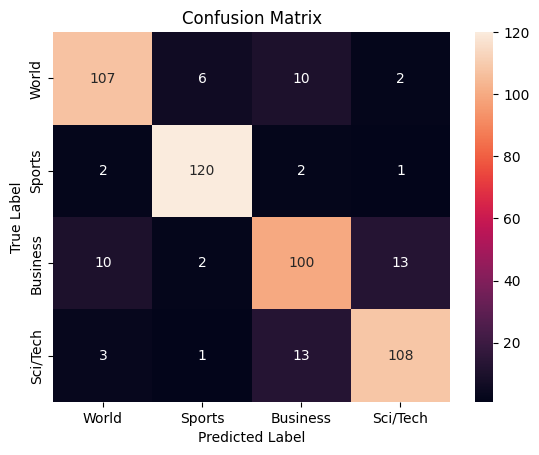

In [37]:
# Calculate macro-f1 score
macro_f1 = f1_score(y_test_BERT, test_predicted_BERT, average='macro')
print(f'Macro F1 Score: {macro_f1:.4f}')

# Calculate classification report
report_BERT = classification_report(y_test_BERT, test_predicted_BERT)
print("Classification Report:")
print(report_BERT)

# Plot confusion matrix
cm = confusion_matrix(y_test_BERT, test_predicted_BERT)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['World', 'Sports', 'Business', 'Sci/Tech'], yticklabels=['World', 'Sports', 'Business', 'Sci/Tech'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [30]:
results_df.head()

,text,label,preds
0,Detainees seen as minimal threat WASHINGTON --...,0,0
1,Japan's army works out plan to cope with North...,0,0
2,UN council arrives in Nairobi UN Security Coun...,0,0
3,APEC Ministers Urge New Effort on Trade Talks ...,0,2
4,At Least Five Dead in Russia Mine Blast (Reute...,0,0


Saving the dataframe of results in form of csv file

In [31]:
results_df.to_csv("bert_test.csv")